In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
def one_hot(y, batch_size):
    oh = torch.zeros([batch_size, class_size])
    for st,idx in enumerate(y):          
        oh[st][idx] = 1 
    return oh   

In [6]:
lr = 0.0001
prior_size = 100
class_size = 10
train_epoch = 1000
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)

fixed_data, fixed_cl = next(iter(test_loader))
fixed_z = torch.randn((50, 100))
fixed_oh = one_hot(y=fixed_cl[:50], batch_size=50)
fixed_h = torch.cat((fixed_z, fixed_oh), 1) 

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [8]:
G = FullyConnected([prior_size + class_size, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28 + class_size, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [9]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [10]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [11]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, cl) in enumerate(train_loader):
        
        # train D
        D.zero_grad()
        G.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        oh = one_hot(y=cl, batch_size=batch_size)
        z_oh = torch.cat((z, oh), 1)     
        #print ('data=', data.shape)
        data_oh = torch.cat((data.view(-1, 28*28), oh), 1)
        fake_oh = torch.cat((G(z_oh), oh), 1)
                
        fake_pred = D(fake_oh)
        true_pred = D(data_oh)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
                
        fake_oh = torch.cat((G(z_oh), oh), 1)
        fake_pred = D(fake_oh)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [12]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, cl in loader:
            
            z = torch.randn((batch_size, prior_size))
            oh = one_hot(y=cl, batch_size=batch_size)
            z_oh = torch.cat((z, oh), 1)         
            data_oh = torch.cat((data.view(-1, 28*28), oh), 1)
            fake_oh = torch.cat((G(z_oh), oh), 1)
        
            fake_pred = D(fake_oh)
            true_pred = D(data_oh)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size
    
    fixed_gen = G(fixed_h).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.7147, D: 0.6848
Train Epoch: 1 [5000/50000 (10%)]	Losses G: 1.2100, D: 0.3669
Train Epoch: 1 [10000/50000 (20%)]	Losses G: 2.4134, D: 0.2396
Train Epoch: 1 [15000/50000 (30%)]	Losses G: 2.7569, D: 0.3083
Train Epoch: 1 [20000/50000 (40%)]	Losses G: 3.4846, D: 0.2272
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 0.6722, D: 0.7813
Train Epoch: 1 [30000/50000 (60%)]	Losses G: 2.0131, D: 0.2298
Train Epoch: 1 [35000/50000 (70%)]	Losses G: 3.1708, D: 0.1235
Train Epoch: 1 [40000/50000 (80%)]	Losses G: 2.3032, D: 0.5174
Train Epoch: 1 [45000/50000 (90%)]	Losses G: 0.9136, D: 0.5995
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 0.6380, D: 0.7490


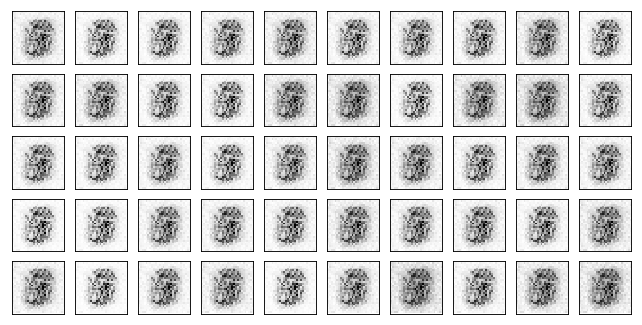

Test losses. G: 0.5806, D: 0.7172
Train Epoch: 2 [0/50000 (0%)]	Losses G: 0.5986, D: 0.7564
Train Epoch: 2 [5000/50000 (10%)]	Losses G: 1.6457, D: 0.3114
Train Epoch: 2 [10000/50000 (20%)]	Losses G: 1.5128, D: 0.4809
Train Epoch: 2 [15000/50000 (30%)]	Losses G: 3.2631, D: 0.3925
Train Epoch: 2 [20000/50000 (40%)]	Losses G: 1.9187, D: 0.2985
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 3.3701, D: 0.0955
Train Epoch: 2 [30000/50000 (60%)]	Losses G: 3.1802, D: 0.1675
Train Epoch: 2 [35000/50000 (70%)]	Losses G: 2.7109, D: 0.2378
Train Epoch: 2 [40000/50000 (80%)]	Losses G: 2.7511, D: 0.1530
Train Epoch: 2 [45000/50000 (90%)]	Losses G: 3.3858, D: 0.0971
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 4.3395, D: 0.2363


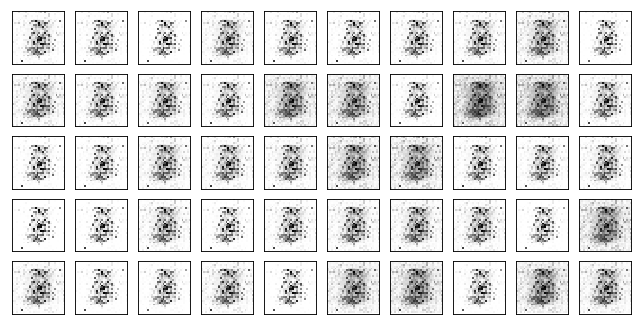

Test losses. G: 3.5064, D: 0.0549
Train Epoch: 3 [0/50000 (0%)]	Losses G: 3.7739, D: 0.2274
Train Epoch: 3 [5000/50000 (10%)]	Losses G: 4.2148, D: 0.0351
Train Epoch: 3 [10000/50000 (20%)]	Losses G: 3.8127, D: 0.1524
Train Epoch: 3 [15000/50000 (30%)]	Losses G: 4.6934, D: 0.1717
Train Epoch: 3 [20000/50000 (40%)]	Losses G: 5.5937, D: 0.0691
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 6.0572, D: 0.0956
Train Epoch: 3 [30000/50000 (60%)]	Losses G: 2.7347, D: 0.3292
Train Epoch: 3 [35000/50000 (70%)]	Losses G: 4.6309, D: 0.0542
Train Epoch: 3 [40000/50000 (80%)]	Losses G: 4.6731, D: 0.0362
Train Epoch: 3 [45000/50000 (90%)]	Losses G: 4.4668, D: 0.1155
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 6.3236, D: 0.1796


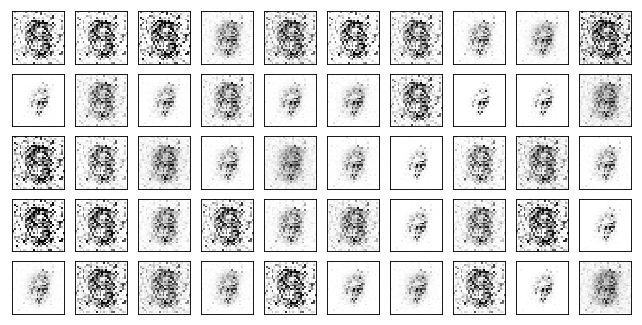

Test losses. G: 4.9809, D: 0.1179
Train Epoch: 4 [0/50000 (0%)]	Losses G: 4.9468, D: 0.2882
Train Epoch: 4 [5000/50000 (10%)]	Losses G: 5.4567, D: 0.1144
Train Epoch: 4 [10000/50000 (20%)]	Losses G: 5.6284, D: 0.1313
Train Epoch: 4 [15000/50000 (30%)]	Losses G: 3.4091, D: 0.0930
Train Epoch: 4 [20000/50000 (40%)]	Losses G: 4.1588, D: 0.1749
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 5.7203, D: 0.1448
Train Epoch: 4 [30000/50000 (60%)]	Losses G: 3.1390, D: 0.1727
Train Epoch: 4 [35000/50000 (70%)]	Losses G: 4.2867, D: 0.1352
Train Epoch: 4 [40000/50000 (80%)]	Losses G: 4.3558, D: 0.1257
Train Epoch: 4 [45000/50000 (90%)]	Losses G: 4.1476, D: 0.1363
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 5.4306, D: 0.2379


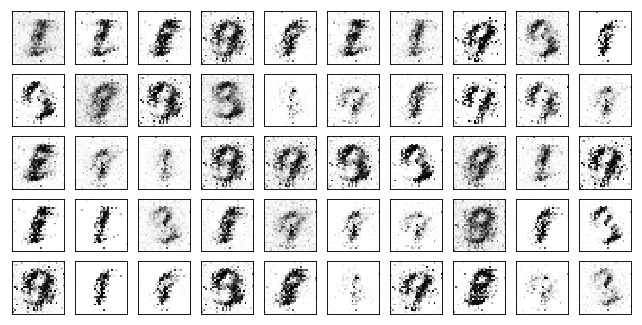

Test losses. G: 4.4779, D: 0.0586
Train Epoch: 5 [0/50000 (0%)]	Losses G: 5.6215, D: 0.1938
Train Epoch: 5 [5000/50000 (10%)]	Losses G: 3.9607, D: 0.1021
Train Epoch: 5 [10000/50000 (20%)]	Losses G: 4.2034, D: 0.1706
Train Epoch: 5 [15000/50000 (30%)]	Losses G: 4.1741, D: 0.1574
Train Epoch: 5 [20000/50000 (40%)]	Losses G: 3.8528, D: 0.1069
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 6.1235, D: 0.1741
Train Epoch: 5 [30000/50000 (60%)]	Losses G: 3.9088, D: 0.2208
Train Epoch: 5 [35000/50000 (70%)]	Losses G: 3.1952, D: 0.1938
Train Epoch: 5 [40000/50000 (80%)]	Losses G: 5.4080, D: 0.0583
Train Epoch: 5 [45000/50000 (90%)]	Losses G: 4.4254, D: 0.1824
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 4.5980, D: 0.1835


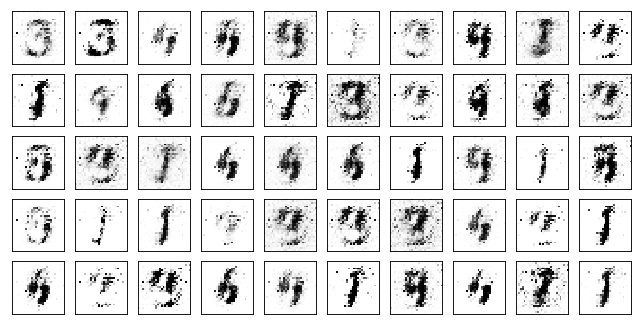

Test losses. G: 3.8249, D: 0.0843
Train Epoch: 6 [0/50000 (0%)]	Losses G: 3.5136, D: 0.2310
Train Epoch: 6 [5000/50000 (10%)]	Losses G: 5.4764, D: 0.1029
Train Epoch: 6 [10000/50000 (20%)]	Losses G: 3.8277, D: 0.0906
Train Epoch: 6 [15000/50000 (30%)]	Losses G: 3.3139, D: 0.2196
Train Epoch: 6 [20000/50000 (40%)]	Losses G: 4.5512, D: 0.1325
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 5.0044, D: 0.1417
Train Epoch: 6 [30000/50000 (60%)]	Losses G: 4.6456, D: 0.0427
Train Epoch: 6 [35000/50000 (70%)]	Losses G: 3.4003, D: 0.3439
Train Epoch: 6 [40000/50000 (80%)]	Losses G: 3.0444, D: 0.1442
Train Epoch: 6 [45000/50000 (90%)]	Losses G: 4.7942, D: 0.0843
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 4.0372, D: 0.3181


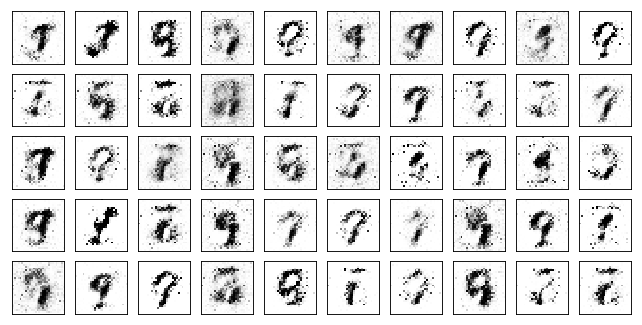

Test losses. G: 3.2947, D: 0.0678
Train Epoch: 7 [0/50000 (0%)]	Losses G: 4.0567, D: 0.2048
Train Epoch: 7 [5000/50000 (10%)]	Losses G: 2.3854, D: 0.1303
Train Epoch: 7 [10000/50000 (20%)]	Losses G: 3.9079, D: 0.1258
Train Epoch: 7 [15000/50000 (30%)]	Losses G: 3.6848, D: 0.2167
Train Epoch: 7 [20000/50000 (40%)]	Losses G: 4.3850, D: 0.1117
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 5.7854, D: 0.2313
Train Epoch: 7 [30000/50000 (60%)]	Losses G: 3.0707, D: 0.1207
Train Epoch: 7 [35000/50000 (70%)]	Losses G: 4.2227, D: 0.1777
Train Epoch: 7 [40000/50000 (80%)]	Losses G: 3.0163, D: 0.1392
Train Epoch: 7 [45000/50000 (90%)]	Losses G: 4.1380, D: 0.2162
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 3.5746, D: 0.1569


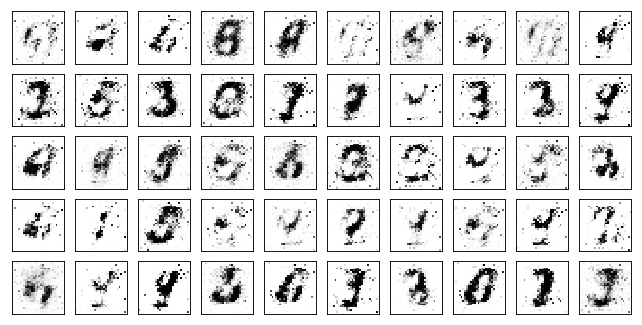

Test losses. G: 3.0506, D: 0.0611
Train Epoch: 8 [0/50000 (0%)]	Losses G: 3.2859, D: 0.1675
Train Epoch: 8 [5000/50000 (10%)]	Losses G: 2.9131, D: 0.2281
Train Epoch: 8 [10000/50000 (20%)]	Losses G: 3.8436, D: 0.1543
Train Epoch: 8 [15000/50000 (30%)]	Losses G: 3.7968, D: 0.2199
Train Epoch: 8 [20000/50000 (40%)]	Losses G: 4.0013, D: 0.2229
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 4.2959, D: 0.2862
Train Epoch: 8 [30000/50000 (60%)]	Losses G: 2.6130, D: 0.3137
Train Epoch: 8 [35000/50000 (70%)]	Losses G: 3.4205, D: 0.2326
Train Epoch: 8 [40000/50000 (80%)]	Losses G: 3.8671, D: 0.2518
Train Epoch: 8 [45000/50000 (90%)]	Losses G: 3.0332, D: 0.2631
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 4.9496, D: 0.1182


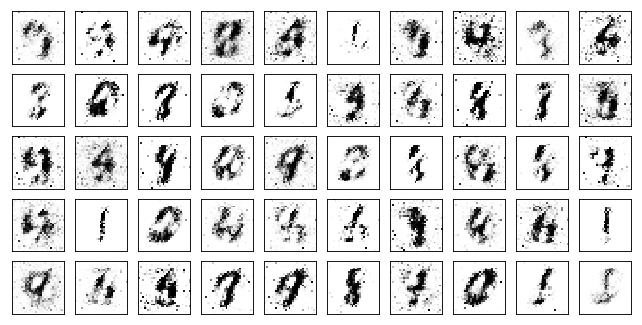

Test losses. G: 4.1358, D: 0.0833
Train Epoch: 9 [0/50000 (0%)]	Losses G: 4.6263, D: 0.1237
Train Epoch: 9 [5000/50000 (10%)]	Losses G: 2.5910, D: 0.1281
Train Epoch: 9 [10000/50000 (20%)]	Losses G: 3.0884, D: 0.1235
Train Epoch: 9 [15000/50000 (30%)]	Losses G: 2.1023, D: 0.3309
Train Epoch: 9 [20000/50000 (40%)]	Losses G: 2.9858, D: 0.2440
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 3.2644, D: 0.1914
Train Epoch: 9 [30000/50000 (60%)]	Losses G: 3.0821, D: 0.2119
Train Epoch: 9 [35000/50000 (70%)]	Losses G: 3.1642, D: 0.2156
Train Epoch: 9 [40000/50000 (80%)]	Losses G: 3.6087, D: 0.2319
Train Epoch: 9 [45000/50000 (90%)]	Losses G: 2.5200, D: 0.2378
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.6262, D: 0.3499


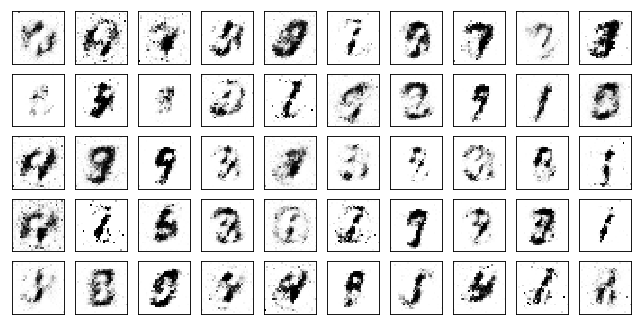

Test losses. G: 3.1430, D: 0.1646
Train Epoch: 10 [0/50000 (0%)]	Losses G: 3.3276, D: 0.3797
Train Epoch: 10 [5000/50000 (10%)]	Losses G: 3.2400, D: 0.2690
Train Epoch: 10 [10000/50000 (20%)]	Losses G: 2.9125, D: 0.2412
Train Epoch: 10 [15000/50000 (30%)]	Losses G: 2.6602, D: 0.3751
Train Epoch: 10 [20000/50000 (40%)]	Losses G: 3.3915, D: 0.2588
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 2.9268, D: 0.2543
Train Epoch: 10 [30000/50000 (60%)]	Losses G: 3.0001, D: 0.3201
Train Epoch: 10 [35000/50000 (70%)]	Losses G: 1.8889, D: 0.2573
Train Epoch: 10 [40000/50000 (80%)]	Losses G: 3.0613, D: 0.1778
Train Epoch: 10 [45000/50000 (90%)]	Losses G: 2.9246, D: 0.2802
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 2.8712, D: 0.2261


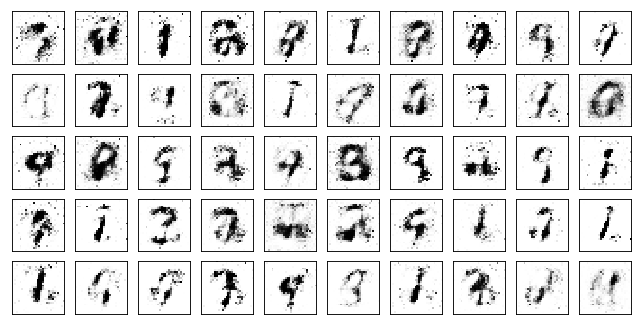

Test losses. G: 2.7161, D: 0.1273
Train Epoch: 11 [0/50000 (0%)]	Losses G: 3.3407, D: 0.1712
Train Epoch: 11 [5000/50000 (10%)]	Losses G: 2.8435, D: 0.2589
Train Epoch: 11 [10000/50000 (20%)]	Losses G: 2.6363, D: 0.2171
Train Epoch: 11 [15000/50000 (30%)]	Losses G: 3.1079, D: 0.2073
Train Epoch: 11 [20000/50000 (40%)]	Losses G: 3.1185, D: 0.1990
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 2.8462, D: 0.3115
Train Epoch: 11 [30000/50000 (60%)]	Losses G: 2.0613, D: 0.2513
Train Epoch: 11 [35000/50000 (70%)]	Losses G: 2.3743, D: 0.2555
Train Epoch: 11 [40000/50000 (80%)]	Losses G: 2.0500, D: 0.3362
Train Epoch: 11 [45000/50000 (90%)]	Losses G: 3.0607, D: 0.2991
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 2.1004, D: 0.2571


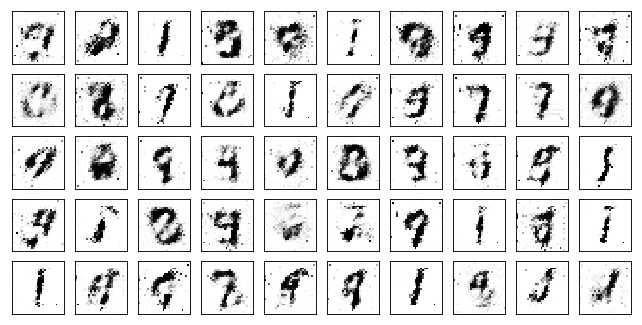

Test losses. G: 1.7730, D: 0.1930
Train Epoch: 12 [0/50000 (0%)]	Losses G: 2.6984, D: 0.2487
Train Epoch: 12 [5000/50000 (10%)]	Losses G: 2.3257, D: 0.2374
Train Epoch: 12 [10000/50000 (20%)]	Losses G: 2.3761, D: 0.2716
Train Epoch: 12 [15000/50000 (30%)]	Losses G: 2.8400, D: 0.2532
Train Epoch: 12 [20000/50000 (40%)]	Losses G: 2.8874, D: 0.2496
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 2.8557, D: 0.3113
Train Epoch: 12 [30000/50000 (60%)]	Losses G: 2.9816, D: 0.2578
Train Epoch: 12 [35000/50000 (70%)]	Losses G: 2.1743, D: 0.4295
Train Epoch: 12 [40000/50000 (80%)]	Losses G: 2.3739, D: 0.4370
Train Epoch: 12 [45000/50000 (90%)]	Losses G: 2.5988, D: 0.3210
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 1.7316, D: 0.3681


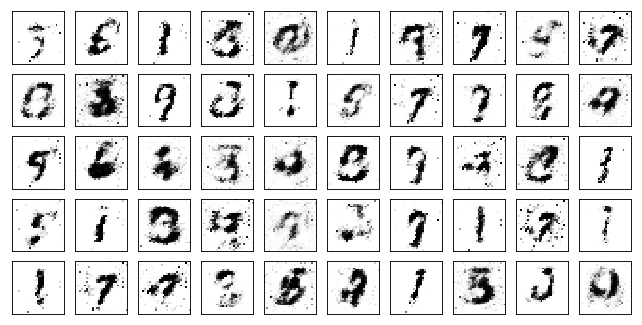

Test losses. G: 1.5132, D: 0.2843
Train Epoch: 13 [0/50000 (0%)]	Losses G: 2.2319, D: 0.4324
Train Epoch: 13 [5000/50000 (10%)]	Losses G: 2.4308, D: 0.3091
Train Epoch: 13 [10000/50000 (20%)]	Losses G: 3.5092, D: 0.2541
Train Epoch: 13 [15000/50000 (30%)]	Losses G: 1.7606, D: 0.2750
Train Epoch: 13 [20000/50000 (40%)]	Losses G: 2.3596, D: 0.2529
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 2.2896, D: 0.3037
Train Epoch: 13 [30000/50000 (60%)]	Losses G: 2.8181, D: 0.4443
Train Epoch: 13 [35000/50000 (70%)]	Losses G: 2.8937, D: 0.2356
Train Epoch: 13 [40000/50000 (80%)]	Losses G: 2.5617, D: 0.1898
Train Epoch: 13 [45000/50000 (90%)]	Losses G: 2.3722, D: 0.2867
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 2.1626, D: 0.3456


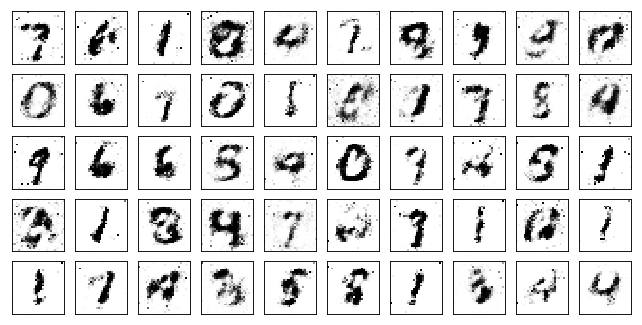

Test losses. G: 2.0445, D: 0.2530
Train Epoch: 14 [0/50000 (0%)]	Losses G: 2.2064, D: 0.3986
Train Epoch: 14 [5000/50000 (10%)]	Losses G: 2.4613, D: 0.3431
Train Epoch: 14 [10000/50000 (20%)]	Losses G: 2.0488, D: 0.4195
Train Epoch: 14 [15000/50000 (30%)]	Losses G: 2.4558, D: 0.2474
Train Epoch: 14 [20000/50000 (40%)]	Losses G: 2.3343, D: 0.2471
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 2.6064, D: 0.3770
Train Epoch: 14 [30000/50000 (60%)]	Losses G: 2.1296, D: 0.2601
Train Epoch: 14 [35000/50000 (70%)]	Losses G: 1.7920, D: 0.4019
Train Epoch: 14 [40000/50000 (80%)]	Losses G: 2.0916, D: 0.4745
Train Epoch: 14 [45000/50000 (90%)]	Losses G: 2.1923, D: 0.4207
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 2.0049, D: 0.4786


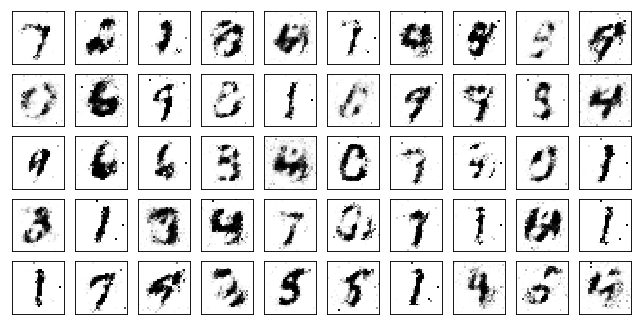

Test losses. G: 2.0404, D: 0.2931
Train Epoch: 15 [0/50000 (0%)]	Losses G: 1.6403, D: 0.4444
Train Epoch: 15 [5000/50000 (10%)]	Losses G: 2.2260, D: 0.2332
Train Epoch: 15 [10000/50000 (20%)]	Losses G: 2.1564, D: 0.3367
Train Epoch: 15 [15000/50000 (30%)]	Losses G: 1.6154, D: 0.5553
Train Epoch: 15 [20000/50000 (40%)]	Losses G: 1.7567, D: 0.3958
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 1.8055, D: 0.3337
Train Epoch: 15 [30000/50000 (60%)]	Losses G: 2.0686, D: 0.4794
Train Epoch: 15 [35000/50000 (70%)]	Losses G: 2.2395, D: 0.3337
Train Epoch: 15 [40000/50000 (80%)]	Losses G: 1.7473, D: 0.2892
Train Epoch: 15 [45000/50000 (90%)]	Losses G: 2.6849, D: 0.4279
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 2.1766, D: 0.5071


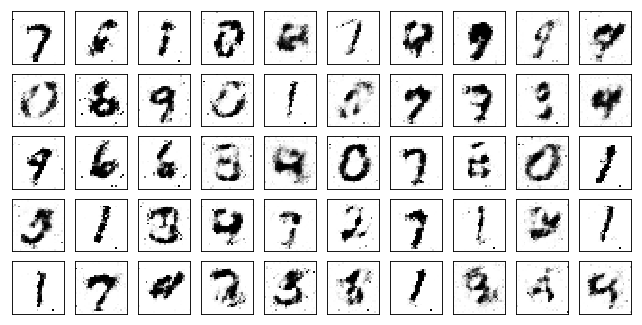

Test losses. G: 2.2634, D: 0.2894
Train Epoch: 16 [0/50000 (0%)]	Losses G: 2.0785, D: 0.3505
Train Epoch: 16 [5000/50000 (10%)]	Losses G: 2.5842, D: 0.3028
Train Epoch: 16 [10000/50000 (20%)]	Losses G: 1.9160, D: 0.3639
Train Epoch: 16 [15000/50000 (30%)]	Losses G: 2.5709, D: 0.2705
Train Epoch: 16 [20000/50000 (40%)]	Losses G: 2.3618, D: 0.3502
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 2.3593, D: 0.2545
Train Epoch: 16 [30000/50000 (60%)]	Losses G: 2.3250, D: 0.3227
Train Epoch: 16 [35000/50000 (70%)]	Losses G: 1.4385, D: 0.6292
Train Epoch: 16 [40000/50000 (80%)]	Losses G: 2.0885, D: 0.3606
Train Epoch: 16 [45000/50000 (90%)]	Losses G: 1.8585, D: 0.4358
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 2.0288, D: 0.4211


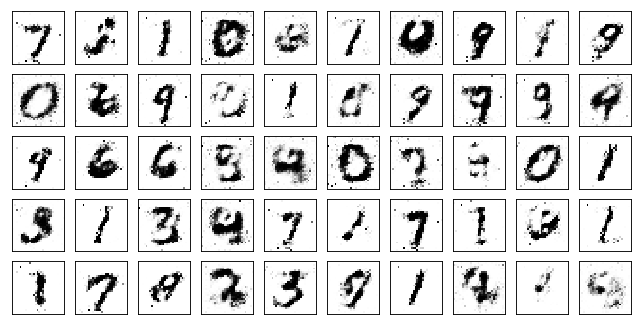

Test losses. G: 1.9298, D: 0.2540
Train Epoch: 17 [0/50000 (0%)]	Losses G: 2.2977, D: 0.3141
Train Epoch: 17 [5000/50000 (10%)]	Losses G: 2.4109, D: 0.2535
Train Epoch: 17 [10000/50000 (20%)]	Losses G: 2.4395, D: 0.2219
Train Epoch: 17 [15000/50000 (30%)]	Losses G: 2.1717, D: 0.3143
Train Epoch: 17 [20000/50000 (40%)]	Losses G: 2.4898, D: 0.4796
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 1.7558, D: 0.4499
Train Epoch: 17 [30000/50000 (60%)]	Losses G: 1.7554, D: 0.5006
Train Epoch: 17 [35000/50000 (70%)]	Losses G: 1.5982, D: 0.3435
Train Epoch: 17 [40000/50000 (80%)]	Losses G: 1.7550, D: 0.4433
Train Epoch: 17 [45000/50000 (90%)]	Losses G: 2.3198, D: 0.3396
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 1.6372, D: 0.3360


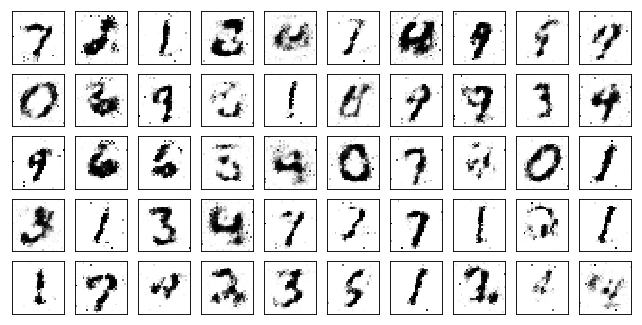

Test losses. G: 1.7344, D: 0.2413
Train Epoch: 18 [0/50000 (0%)]	Losses G: 1.8319, D: 0.3482
Train Epoch: 18 [5000/50000 (10%)]	Losses G: 1.5360, D: 0.5607
Train Epoch: 18 [10000/50000 (20%)]	Losses G: 2.1629, D: 0.3759
Train Epoch: 18 [15000/50000 (30%)]	Losses G: 2.0162, D: 0.3919
Train Epoch: 18 [20000/50000 (40%)]	Losses G: 2.3018, D: 0.2958
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 1.9367, D: 0.4335
Train Epoch: 18 [30000/50000 (60%)]	Losses G: 1.4600, D: 0.5400
Train Epoch: 18 [35000/50000 (70%)]	Losses G: 1.9685, D: 0.5330
Train Epoch: 18 [40000/50000 (80%)]	Losses G: 2.2168, D: 0.3639
Train Epoch: 18 [45000/50000 (90%)]	Losses G: 1.9098, D: 0.3953
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 1.9963, D: 0.3234


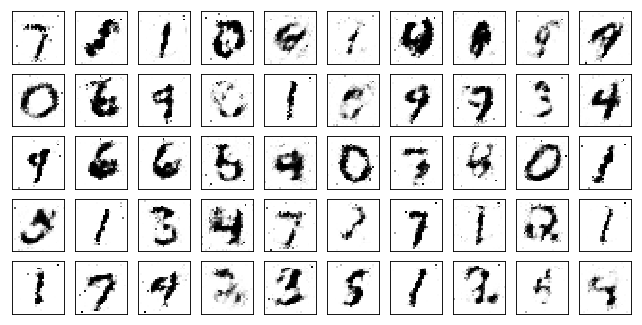

Test losses. G: 2.0457, D: 0.3492
Train Epoch: 19 [0/50000 (0%)]	Losses G: 2.2728, D: 0.4369
Train Epoch: 19 [5000/50000 (10%)]	Losses G: 1.5209, D: 0.3348
Train Epoch: 19 [10000/50000 (20%)]	Losses G: 1.7447, D: 0.4309
Train Epoch: 19 [15000/50000 (30%)]	Losses G: 1.6670, D: 0.4160
Train Epoch: 19 [20000/50000 (40%)]	Losses G: 2.1946, D: 0.3796
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 1.4011, D: 0.4420
Train Epoch: 19 [30000/50000 (60%)]	Losses G: 1.5982, D: 0.4689
Train Epoch: 19 [35000/50000 (70%)]	Losses G: 1.6728, D: 0.3271
Train Epoch: 19 [40000/50000 (80%)]	Losses G: 2.0667, D: 0.2834
Train Epoch: 19 [45000/50000 (90%)]	Losses G: 1.8847, D: 0.4029
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 1.6089, D: 0.3718


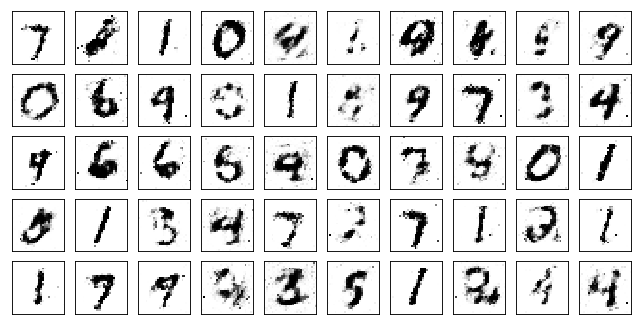

Test losses. G: 1.8931, D: 0.2862
Train Epoch: 20 [0/50000 (0%)]	Losses G: 2.0337, D: 0.3324
Train Epoch: 20 [5000/50000 (10%)]	Losses G: 1.4848, D: 0.4705
Train Epoch: 20 [10000/50000 (20%)]	Losses G: 1.6238, D: 0.4666
Train Epoch: 20 [15000/50000 (30%)]	Losses G: 2.0071, D: 0.3049
Train Epoch: 20 [20000/50000 (40%)]	Losses G: 1.6428, D: 0.4557
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 1.9657, D: 0.3724
Train Epoch: 20 [30000/50000 (60%)]	Losses G: 1.8966, D: 0.3630
Train Epoch: 20 [35000/50000 (70%)]	Losses G: 1.6835, D: 0.4211
Train Epoch: 20 [40000/50000 (80%)]	Losses G: 2.0869, D: 0.3974
Train Epoch: 20 [45000/50000 (90%)]	Losses G: 2.0439, D: 0.4690
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 2.1222, D: 0.2750


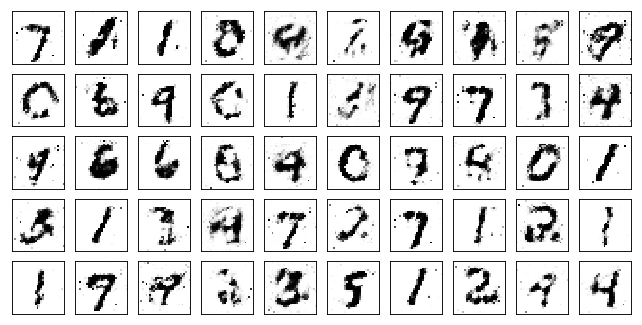

Test losses. G: 2.1656, D: 0.2979
Train Epoch: 21 [0/50000 (0%)]	Losses G: 2.2180, D: 0.3006
Train Epoch: 21 [5000/50000 (10%)]	Losses G: 1.7937, D: 0.4460
Train Epoch: 21 [10000/50000 (20%)]	Losses G: 1.7643, D: 0.4117
Train Epoch: 21 [15000/50000 (30%)]	Losses G: 1.4499, D: 0.3753
Train Epoch: 21 [20000/50000 (40%)]	Losses G: 2.2296, D: 0.3780
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 1.7908, D: 0.3778
Train Epoch: 21 [30000/50000 (60%)]	Losses G: 1.9184, D: 0.3271
Train Epoch: 21 [35000/50000 (70%)]	Losses G: 1.3363, D: 0.3460
Train Epoch: 21 [40000/50000 (80%)]	Losses G: 1.7635, D: 0.4713
Train Epoch: 21 [45000/50000 (90%)]	Losses G: 1.3606, D: 0.4657
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 1.6144, D: 0.5010


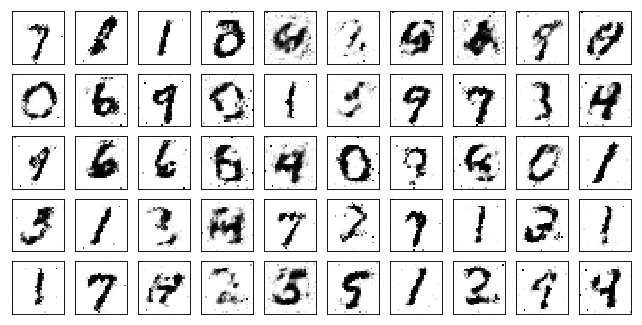

Test losses. G: 1.6266, D: 0.4287
Train Epoch: 22 [0/50000 (0%)]	Losses G: 1.8055, D: 0.5951
Train Epoch: 22 [5000/50000 (10%)]	Losses G: 1.5810, D: 0.3908
Train Epoch: 22 [10000/50000 (20%)]	Losses G: 1.7506, D: 0.4553
Train Epoch: 22 [15000/50000 (30%)]	Losses G: 1.5048, D: 0.5875
Train Epoch: 22 [20000/50000 (40%)]	Losses G: 1.8812, D: 0.5809
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 1.3280, D: 0.5196
Train Epoch: 22 [30000/50000 (60%)]	Losses G: 1.4435, D: 0.4655
Train Epoch: 22 [35000/50000 (70%)]	Losses G: 1.7301, D: 0.4296
Train Epoch: 22 [40000/50000 (80%)]	Losses G: 1.8212, D: 0.4000
Train Epoch: 22 [45000/50000 (90%)]	Losses G: 1.3365, D: 0.3423
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 1.7007, D: 0.4708


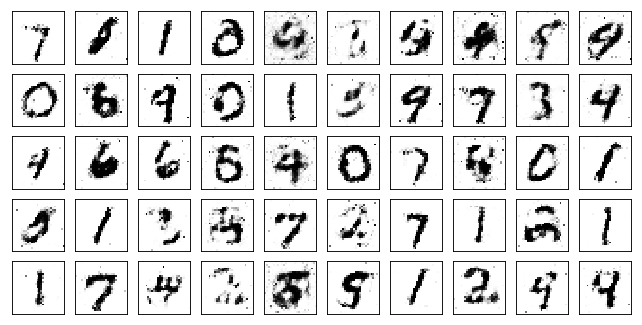

Test losses. G: 1.7780, D: 0.3033
Train Epoch: 23 [0/50000 (0%)]	Losses G: 1.9102, D: 0.3875
Train Epoch: 23 [5000/50000 (10%)]	Losses G: 1.5524, D: 0.4212
Train Epoch: 23 [10000/50000 (20%)]	Losses G: 1.4576, D: 0.4588
Train Epoch: 23 [15000/50000 (30%)]	Losses G: 1.1940, D: 0.4751
Train Epoch: 23 [20000/50000 (40%)]	Losses G: 1.6789, D: 0.4099
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 1.7191, D: 0.4476
Train Epoch: 23 [30000/50000 (60%)]	Losses G: 1.4062, D: 0.3878
Train Epoch: 23 [35000/50000 (70%)]	Losses G: 1.2875, D: 0.4679
Train Epoch: 23 [40000/50000 (80%)]	Losses G: 1.8014, D: 0.4886
Train Epoch: 23 [45000/50000 (90%)]	Losses G: 1.6541, D: 0.4965
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 1.6513, D: 0.4217


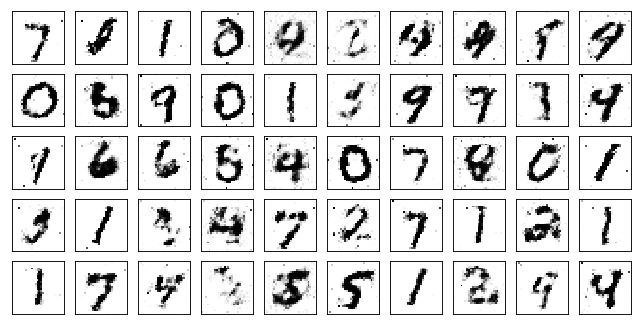

Test losses. G: 1.4684, D: 0.4131
Train Epoch: 24 [0/50000 (0%)]	Losses G: 1.5063, D: 0.5844
Train Epoch: 24 [5000/50000 (10%)]	Losses G: 1.3497, D: 0.4637
Train Epoch: 24 [10000/50000 (20%)]	Losses G: 1.7117, D: 0.3891
Train Epoch: 24 [15000/50000 (30%)]	Losses G: 1.3866, D: 0.4551
Train Epoch: 24 [20000/50000 (40%)]	Losses G: 1.8590, D: 0.4127
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 1.5762, D: 0.4686
Train Epoch: 24 [30000/50000 (60%)]	Losses G: 1.3713, D: 0.5323
Train Epoch: 24 [35000/50000 (70%)]	Losses G: 1.4867, D: 0.5495
Train Epoch: 24 [40000/50000 (80%)]	Losses G: 1.7173, D: 0.3411
Train Epoch: 24 [45000/50000 (90%)]	Losses G: 1.6628, D: 0.3865
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 1.6757, D: 0.3867


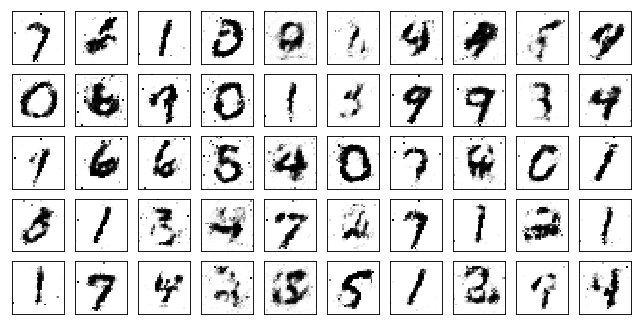

Test losses. G: 1.5198, D: 0.3674
Train Epoch: 25 [0/50000 (0%)]	Losses G: 1.5439, D: 0.3988
Train Epoch: 25 [5000/50000 (10%)]	Losses G: 1.4121, D: 0.3668
Train Epoch: 25 [10000/50000 (20%)]	Losses G: 1.3214, D: 0.5023
Train Epoch: 25 [15000/50000 (30%)]	Losses G: 1.9390, D: 0.4599
Train Epoch: 25 [20000/50000 (40%)]	Losses G: 1.4148, D: 0.4767
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 1.6210, D: 0.5094
Train Epoch: 25 [30000/50000 (60%)]	Losses G: 1.6058, D: 0.4607
Train Epoch: 25 [35000/50000 (70%)]	Losses G: 1.6976, D: 0.3894
Train Epoch: 25 [40000/50000 (80%)]	Losses G: 1.3565, D: 0.4876
Train Epoch: 25 [45000/50000 (90%)]	Losses G: 1.1611, D: 0.4810
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 1.3467, D: 0.4954


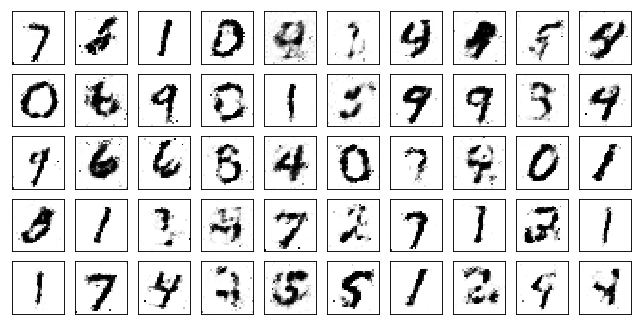

Test losses. G: 1.2842, D: 0.4012
Train Epoch: 26 [0/50000 (0%)]	Losses G: 1.4827, D: 0.5245
Train Epoch: 26 [5000/50000 (10%)]	Losses G: 1.8448, D: 0.4760
Train Epoch: 26 [10000/50000 (20%)]	Losses G: 1.5571, D: 0.4096
Train Epoch: 26 [15000/50000 (30%)]	Losses G: 1.4942, D: 0.5398
Train Epoch: 26 [20000/50000 (40%)]	Losses G: 1.2132, D: 0.6111
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 1.1378, D: 0.5856
Train Epoch: 26 [30000/50000 (60%)]	Losses G: 1.6639, D: 0.5004
Train Epoch: 26 [35000/50000 (70%)]	Losses G: 1.2724, D: 0.5387
Train Epoch: 26 [40000/50000 (80%)]	Losses G: 1.6870, D: 0.3986
Train Epoch: 26 [45000/50000 (90%)]	Losses G: 1.8684, D: 0.4768
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 1.3678, D: 0.4432


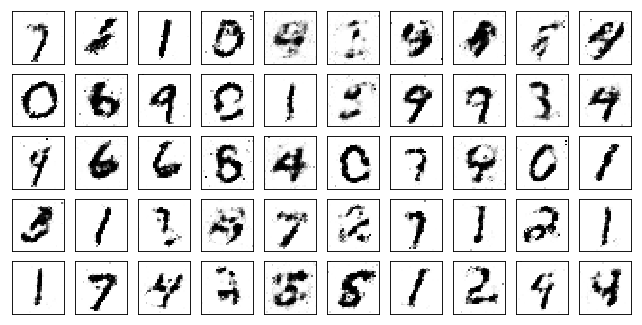

Test losses. G: 1.3173, D: 0.4215
Train Epoch: 27 [0/50000 (0%)]	Losses G: 1.3456, D: 0.4337
Train Epoch: 27 [5000/50000 (10%)]	Losses G: 1.4893, D: 0.5063
Train Epoch: 27 [10000/50000 (20%)]	Losses G: 1.3862, D: 0.5246
Train Epoch: 27 [15000/50000 (30%)]	Losses G: 1.4725, D: 0.4387
Train Epoch: 27 [20000/50000 (40%)]	Losses G: 1.8723, D: 0.5234
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 1.9515, D: 0.3917
Train Epoch: 27 [30000/50000 (60%)]	Losses G: 1.4877, D: 0.4082
Train Epoch: 27 [35000/50000 (70%)]	Losses G: 1.3952, D: 0.4222
Train Epoch: 27 [40000/50000 (80%)]	Losses G: 1.4524, D: 0.5963
Train Epoch: 27 [45000/50000 (90%)]	Losses G: 1.4932, D: 0.5374
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 1.6078, D: 0.4891


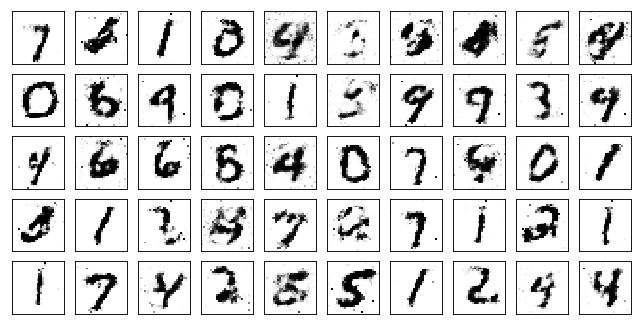

Test losses. G: 1.3356, D: 0.4755
Train Epoch: 28 [0/50000 (0%)]	Losses G: 1.0828, D: 0.5866
Train Epoch: 28 [5000/50000 (10%)]	Losses G: 1.4281, D: 0.4898
Train Epoch: 28 [10000/50000 (20%)]	Losses G: 1.4601, D: 0.4576
Train Epoch: 28 [15000/50000 (30%)]	Losses G: 1.6977, D: 0.4437
Train Epoch: 28 [20000/50000 (40%)]	Losses G: 1.6630, D: 0.3901
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 1.1907, D: 0.5604
Train Epoch: 28 [30000/50000 (60%)]	Losses G: 1.1793, D: 0.5099
Train Epoch: 28 [35000/50000 (70%)]	Losses G: 1.5097, D: 0.5747
Train Epoch: 28 [40000/50000 (80%)]	Losses G: 1.4258, D: 0.4768
Train Epoch: 28 [45000/50000 (90%)]	Losses G: 1.6259, D: 0.4473
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 1.4869, D: 0.4132


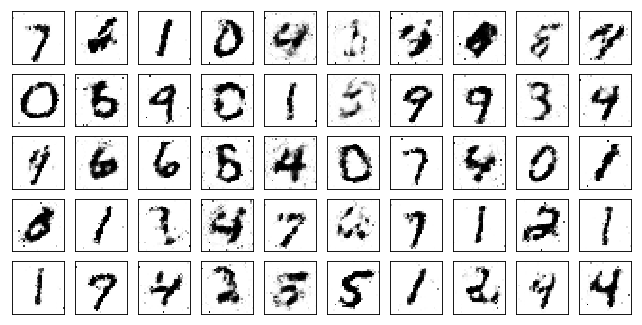

Test losses. G: 1.4803, D: 0.4044
Train Epoch: 29 [0/50000 (0%)]	Losses G: 1.4003, D: 0.4890
Train Epoch: 29 [5000/50000 (10%)]	Losses G: 1.3494, D: 0.5061
Train Epoch: 29 [10000/50000 (20%)]	Losses G: 1.2369, D: 0.5344
Train Epoch: 29 [15000/50000 (30%)]	Losses G: 1.0035, D: 0.4602
Train Epoch: 29 [20000/50000 (40%)]	Losses G: 1.1924, D: 0.5611
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 1.0246, D: 0.6564
Train Epoch: 29 [30000/50000 (60%)]	Losses G: 1.4011, D: 0.5728
Train Epoch: 29 [35000/50000 (70%)]	Losses G: 1.5515, D: 0.5045
Train Epoch: 29 [40000/50000 (80%)]	Losses G: 1.0382, D: 0.6658
Train Epoch: 29 [45000/50000 (90%)]	Losses G: 1.2665, D: 0.5323
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 1.7410, D: 0.3981


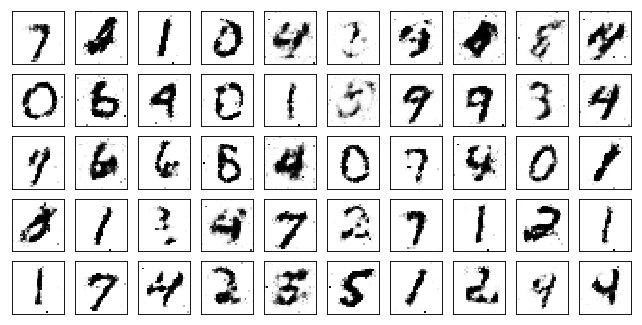

Test losses. G: 1.5323, D: 0.3934
Train Epoch: 30 [0/50000 (0%)]	Losses G: 1.5100, D: 0.4982
Train Epoch: 30 [5000/50000 (10%)]	Losses G: 1.4597, D: 0.5071
Train Epoch: 30 [10000/50000 (20%)]	Losses G: 1.2440, D: 0.4338
Train Epoch: 30 [15000/50000 (30%)]	Losses G: 1.3767, D: 0.4961
Train Epoch: 30 [20000/50000 (40%)]	Losses G: 1.0016, D: 0.7009
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 1.5745, D: 0.5775
Train Epoch: 30 [30000/50000 (60%)]	Losses G: 1.1721, D: 0.5721
Train Epoch: 30 [35000/50000 (70%)]	Losses G: 1.2937, D: 0.4708
Train Epoch: 30 [40000/50000 (80%)]	Losses G: 1.2995, D: 0.5211
Train Epoch: 30 [45000/50000 (90%)]	Losses G: 1.5315, D: 0.5304
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 1.3662, D: 0.4818


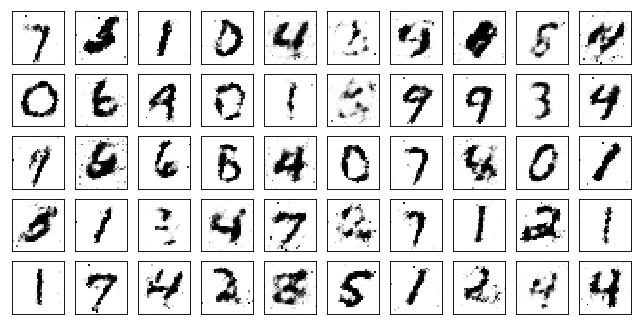

Test losses. G: 1.3448, D: 0.4310
Train Epoch: 31 [0/50000 (0%)]	Losses G: 1.5811, D: 0.3880
Train Epoch: 31 [5000/50000 (10%)]	Losses G: 1.1268, D: 0.5195
Train Epoch: 31 [10000/50000 (20%)]	Losses G: 1.4042, D: 0.5171
Train Epoch: 31 [15000/50000 (30%)]	Losses G: 1.2178, D: 0.5167
Train Epoch: 31 [20000/50000 (40%)]	Losses G: 1.5069, D: 0.4595
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 1.2397, D: 0.4701
Train Epoch: 31 [30000/50000 (60%)]	Losses G: 1.4610, D: 0.5568
Train Epoch: 31 [35000/50000 (70%)]	Losses G: 1.1032, D: 0.6022
Train Epoch: 31 [40000/50000 (80%)]	Losses G: 1.2229, D: 0.4506
Train Epoch: 31 [45000/50000 (90%)]	Losses G: 0.9650, D: 0.5800
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 1.3190, D: 0.5872


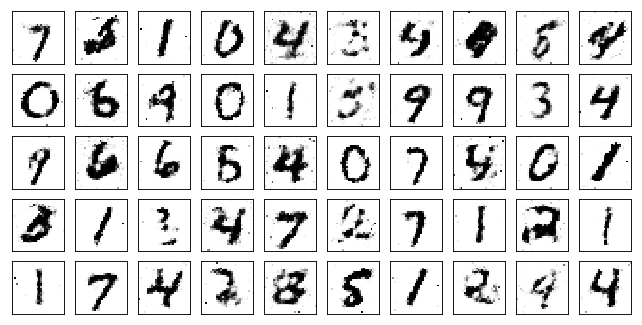

Test losses. G: 1.3271, D: 0.4899
Train Epoch: 32 [0/50000 (0%)]	Losses G: 1.4192, D: 0.4733
Train Epoch: 32 [5000/50000 (10%)]	Losses G: 1.3878, D: 0.4104
Train Epoch: 32 [10000/50000 (20%)]	Losses G: 1.2886, D: 0.4395
Train Epoch: 32 [15000/50000 (30%)]	Losses G: 1.6556, D: 0.5326
Train Epoch: 32 [20000/50000 (40%)]	Losses G: 1.2505, D: 0.5346
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 1.2070, D: 0.4750
Train Epoch: 32 [30000/50000 (60%)]	Losses G: 1.0217, D: 0.5091
Train Epoch: 32 [35000/50000 (70%)]	Losses G: 1.2925, D: 0.4196
Train Epoch: 32 [40000/50000 (80%)]	Losses G: 1.4839, D: 0.5767
Train Epoch: 32 [45000/50000 (90%)]	Losses G: 1.3413, D: 0.4995
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 1.1105, D: 0.5137


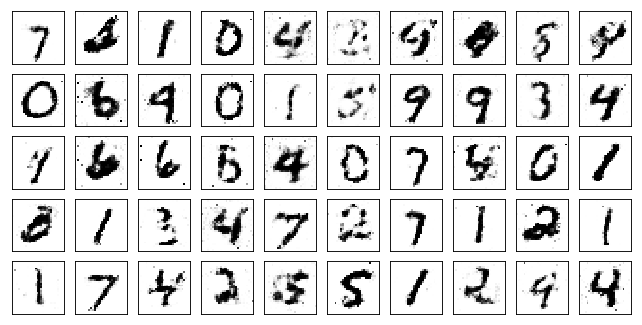

Test losses. G: 1.2404, D: 0.5270
Train Epoch: 33 [0/50000 (0%)]	Losses G: 1.3668, D: 0.6830
Train Epoch: 33 [5000/50000 (10%)]	Losses G: 1.1133, D: 0.6237
Train Epoch: 33 [10000/50000 (20%)]	Losses G: 1.3470, D: 0.5195
Train Epoch: 33 [15000/50000 (30%)]	Losses G: 1.2110, D: 0.4835
Train Epoch: 33 [20000/50000 (40%)]	Losses G: 1.4477, D: 0.4741
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 1.1361, D: 0.5804
Train Epoch: 33 [30000/50000 (60%)]	Losses G: 1.0386, D: 0.5330
Train Epoch: 33 [35000/50000 (70%)]	Losses G: 1.6529, D: 0.5325
Train Epoch: 33 [40000/50000 (80%)]	Losses G: 1.3617, D: 0.5052
Train Epoch: 33 [45000/50000 (90%)]	Losses G: 1.1292, D: 0.5240
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 1.4600, D: 0.6131


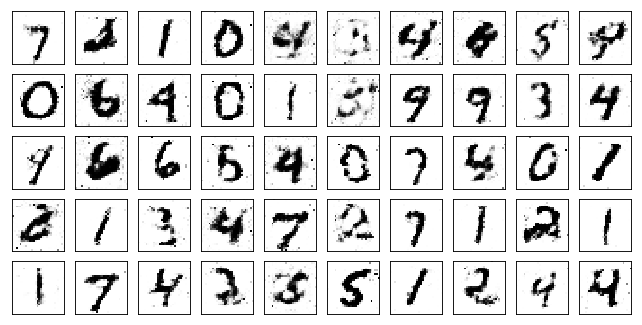

Test losses. G: 1.3070, D: 0.5402
Train Epoch: 34 [0/50000 (0%)]	Losses G: 1.1473, D: 0.5775
Train Epoch: 34 [5000/50000 (10%)]	Losses G: 1.3783, D: 0.6062
Train Epoch: 34 [10000/50000 (20%)]	Losses G: 1.1329, D: 0.4656
Train Epoch: 34 [15000/50000 (30%)]	Losses G: 1.1217, D: 0.5322
Train Epoch: 34 [20000/50000 (40%)]	Losses G: 1.5772, D: 0.6322
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 1.3616, D: 0.4302
Train Epoch: 34 [30000/50000 (60%)]	Losses G: 1.1945, D: 0.5506
Train Epoch: 34 [35000/50000 (70%)]	Losses G: 1.7153, D: 0.5107
Train Epoch: 34 [40000/50000 (80%)]	Losses G: 1.3256, D: 0.5218
Train Epoch: 34 [45000/50000 (90%)]	Losses G: 1.3183, D: 0.4540
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 1.3975, D: 0.5621


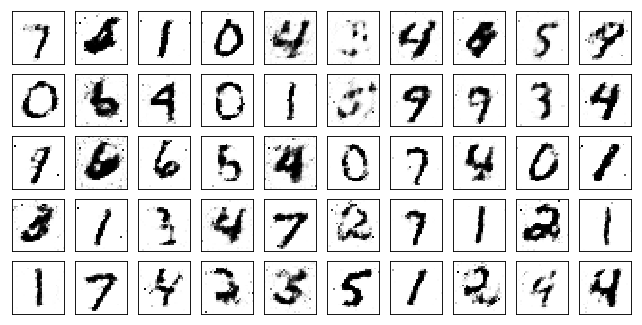

Test losses. G: 1.1628, D: 0.4661
Train Epoch: 35 [0/50000 (0%)]	Losses G: 1.0848, D: 0.5551
Train Epoch: 35 [5000/50000 (10%)]	Losses G: 1.3201, D: 0.6053
Train Epoch: 35 [10000/50000 (20%)]	Losses G: 1.6997, D: 0.4452
Train Epoch: 35 [15000/50000 (30%)]	Losses G: 1.4296, D: 0.4865
Train Epoch: 35 [20000/50000 (40%)]	Losses G: 1.6228, D: 0.5040
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 1.2214, D: 0.5251
Train Epoch: 35 [30000/50000 (60%)]	Losses G: 1.4028, D: 0.4934
Train Epoch: 35 [35000/50000 (70%)]	Losses G: 1.2223, D: 0.5555
Train Epoch: 35 [40000/50000 (80%)]	Losses G: 1.1343, D: 0.5998
Train Epoch: 35 [45000/50000 (90%)]	Losses G: 0.6274, D: 0.6656
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 1.3618, D: 0.6142


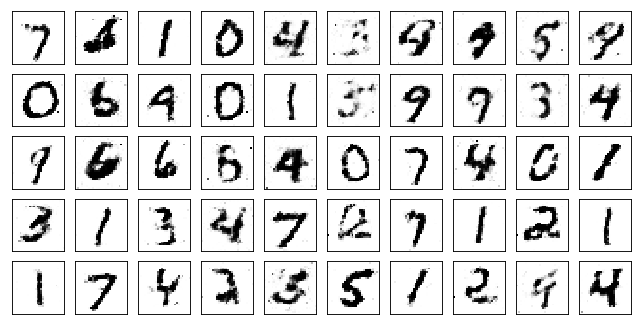

Test losses. G: 1.2081, D: 0.4764
Train Epoch: 36 [0/50000 (0%)]	Losses G: 1.1970, D: 0.6271
Train Epoch: 36 [5000/50000 (10%)]	Losses G: 1.4296, D: 0.5076
Train Epoch: 36 [10000/50000 (20%)]	Losses G: 1.0062, D: 0.5266
Train Epoch: 36 [15000/50000 (30%)]	Losses G: 1.1684, D: 0.6183
Train Epoch: 36 [20000/50000 (40%)]	Losses G: 1.3638, D: 0.4999
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 1.4770, D: 0.5640
Train Epoch: 36 [30000/50000 (60%)]	Losses G: 0.9518, D: 0.5419
Train Epoch: 36 [35000/50000 (70%)]	Losses G: 1.2026, D: 0.5921
Train Epoch: 36 [40000/50000 (80%)]	Losses G: 1.2404, D: 0.5249
Train Epoch: 36 [45000/50000 (90%)]	Losses G: 1.0079, D: 0.6401
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 1.2722, D: 0.6525


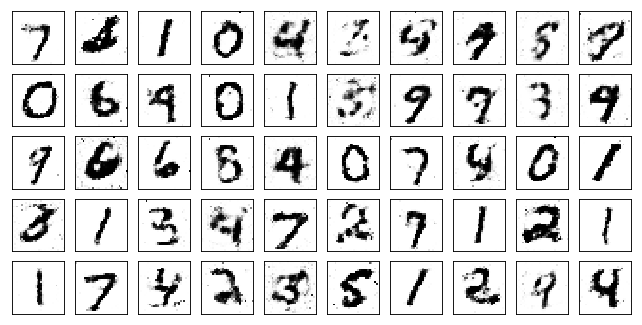

Test losses. G: 1.3578, D: 0.5398
Train Epoch: 37 [0/50000 (0%)]	Losses G: 1.3911, D: 0.5504
Train Epoch: 37 [5000/50000 (10%)]	Losses G: 1.6569, D: 0.4931
Train Epoch: 37 [10000/50000 (20%)]	Losses G: 1.4125, D: 0.5507
Train Epoch: 37 [15000/50000 (30%)]	Losses G: 1.4639, D: 0.4607
Train Epoch: 37 [20000/50000 (40%)]	Losses G: 1.3783, D: 0.5339
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 1.2683, D: 0.5444
Train Epoch: 37 [30000/50000 (60%)]	Losses G: 1.3130, D: 0.5555
Train Epoch: 37 [35000/50000 (70%)]	Losses G: 1.0976, D: 0.6158
Train Epoch: 37 [40000/50000 (80%)]	Losses G: 1.1204, D: 0.5498
Train Epoch: 37 [45000/50000 (90%)]	Losses G: 1.3813, D: 0.5647
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 1.0462, D: 0.5562


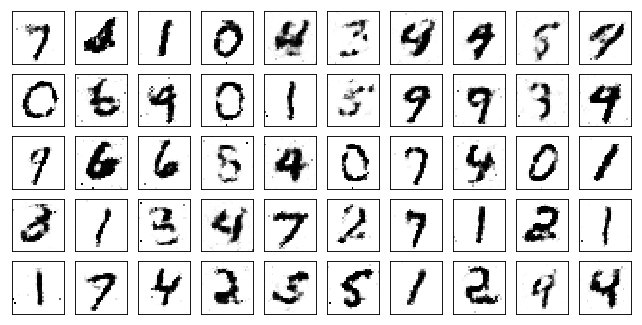

Test losses. G: 1.1997, D: 0.5001
Train Epoch: 38 [0/50000 (0%)]	Losses G: 1.0330, D: 0.5539
Train Epoch: 38 [5000/50000 (10%)]	Losses G: 1.1135, D: 0.6136
Train Epoch: 38 [10000/50000 (20%)]	Losses G: 1.2930, D: 0.4754
Train Epoch: 38 [15000/50000 (30%)]	Losses G: 1.2486, D: 0.5742
Train Epoch: 38 [20000/50000 (40%)]	Losses G: 1.1717, D: 0.5674
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 1.2157, D: 0.5530
Train Epoch: 38 [30000/50000 (60%)]	Losses G: 0.9116, D: 0.5278
Train Epoch: 38 [35000/50000 (70%)]	Losses G: 1.2142, D: 0.5370
Train Epoch: 38 [40000/50000 (80%)]	Losses G: 1.3293, D: 0.5701
Train Epoch: 38 [45000/50000 (90%)]	Losses G: 0.9897, D: 0.5977
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 1.2084, D: 0.6149


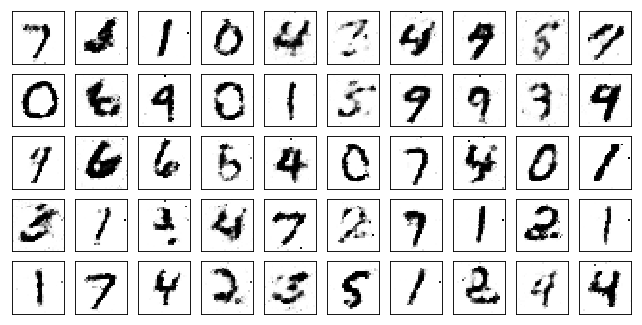

Test losses. G: 1.3168, D: 0.5115
Train Epoch: 39 [0/50000 (0%)]	Losses G: 1.2006, D: 0.5286
Train Epoch: 39 [5000/50000 (10%)]	Losses G: 1.2145, D: 0.5078
Train Epoch: 39 [10000/50000 (20%)]	Losses G: 1.0834, D: 0.4605
Train Epoch: 39 [15000/50000 (30%)]	Losses G: 1.2300, D: 0.5316
Train Epoch: 39 [20000/50000 (40%)]	Losses G: 1.2387, D: 0.4355
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 0.8497, D: 0.6215
Train Epoch: 39 [30000/50000 (60%)]	Losses G: 1.4259, D: 0.4479
Train Epoch: 39 [35000/50000 (70%)]	Losses G: 1.2453, D: 0.5761
Train Epoch: 39 [40000/50000 (80%)]	Losses G: 1.4252, D: 0.5429
Train Epoch: 39 [45000/50000 (90%)]	Losses G: 1.2966, D: 0.5186
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.1176, D: 0.6226


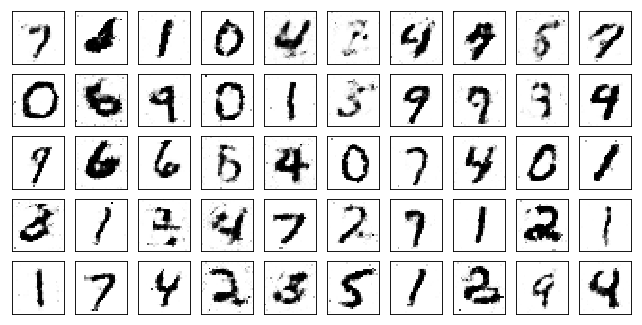

Test losses. G: 1.2537, D: 0.4982
Train Epoch: 40 [0/50000 (0%)]	Losses G: 1.1789, D: 0.5273
Train Epoch: 40 [5000/50000 (10%)]	Losses G: 1.2487, D: 0.5276
Train Epoch: 40 [10000/50000 (20%)]	Losses G: 1.0759, D: 0.5200
Train Epoch: 40 [15000/50000 (30%)]	Losses G: 1.0891, D: 0.5793
Train Epoch: 40 [20000/50000 (40%)]	Losses G: 1.3423, D: 0.5741
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 1.3939, D: 0.5467
Train Epoch: 40 [30000/50000 (60%)]	Losses G: 1.0890, D: 0.5710
Train Epoch: 40 [35000/50000 (70%)]	Losses G: 1.2851, D: 0.5494
Train Epoch: 40 [40000/50000 (80%)]	Losses G: 0.9329, D: 0.6461
Train Epoch: 40 [45000/50000 (90%)]	Losses G: 1.1825, D: 0.6223
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 1.4711, D: 0.5565


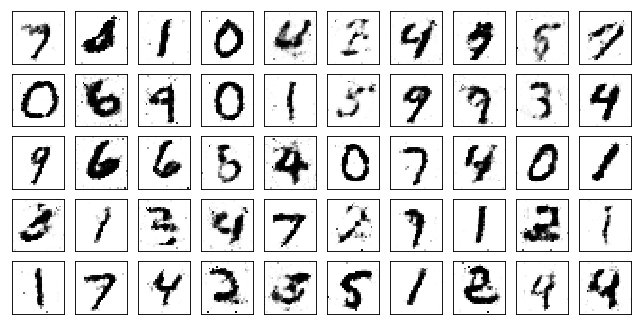

Test losses. G: 1.3436, D: 0.5070
Train Epoch: 41 [0/50000 (0%)]	Losses G: 1.4600, D: 0.6296
Train Epoch: 41 [5000/50000 (10%)]	Losses G: 0.9256, D: 0.6195
Train Epoch: 41 [10000/50000 (20%)]	Losses G: 1.0626, D: 0.5621
Train Epoch: 41 [15000/50000 (30%)]	Losses G: 1.0036, D: 0.5894
Train Epoch: 41 [20000/50000 (40%)]	Losses G: 1.0796, D: 0.6062
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 1.2516, D: 0.6225
Train Epoch: 41 [30000/50000 (60%)]	Losses G: 1.1724, D: 0.6016
Train Epoch: 41 [35000/50000 (70%)]	Losses G: 1.2739, D: 0.5379
Train Epoch: 41 [40000/50000 (80%)]	Losses G: 1.0728, D: 0.5307
Train Epoch: 41 [45000/50000 (90%)]	Losses G: 1.0815, D: 0.5733
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 1.0061, D: 0.4575


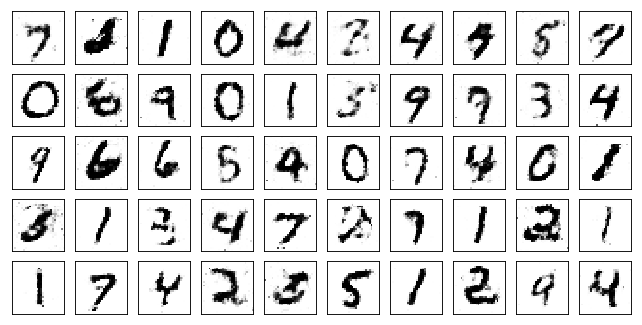

Test losses. G: 1.0526, D: 0.5305
Train Epoch: 42 [0/50000 (0%)]	Losses G: 1.1513, D: 0.5034
Train Epoch: 42 [5000/50000 (10%)]	Losses G: 1.1268, D: 0.6271
Train Epoch: 42 [10000/50000 (20%)]	Losses G: 1.3415, D: 0.5404
Train Epoch: 42 [15000/50000 (30%)]	Losses G: 1.2411, D: 0.6287
Train Epoch: 42 [20000/50000 (40%)]	Losses G: 1.2968, D: 0.5261
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 0.9481, D: 0.6012
Train Epoch: 42 [30000/50000 (60%)]	Losses G: 1.1278, D: 0.5839
Train Epoch: 42 [35000/50000 (70%)]	Losses G: 1.2306, D: 0.5699
Train Epoch: 42 [40000/50000 (80%)]	Losses G: 1.1951, D: 0.4895
Train Epoch: 42 [45000/50000 (90%)]	Losses G: 1.0800, D: 0.5474
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 0.9338, D: 0.4989


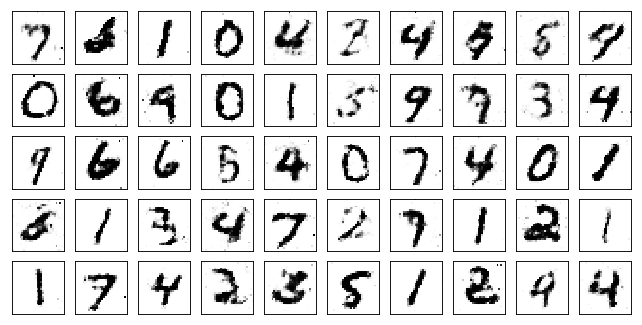

Test losses. G: 1.0056, D: 0.4903
Train Epoch: 43 [0/50000 (0%)]	Losses G: 0.9081, D: 0.5006
Train Epoch: 43 [5000/50000 (10%)]	Losses G: 1.0303, D: 0.6047
Train Epoch: 43 [10000/50000 (20%)]	Losses G: 0.9823, D: 0.6313
Train Epoch: 43 [15000/50000 (30%)]	Losses G: 0.9545, D: 0.6660
Train Epoch: 43 [20000/50000 (40%)]	Losses G: 1.0314, D: 0.5995
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 1.1518, D: 0.5965
Train Epoch: 43 [30000/50000 (60%)]	Losses G: 1.0936, D: 0.6243
Train Epoch: 43 [35000/50000 (70%)]	Losses G: 1.1234, D: 0.6166
Train Epoch: 43 [40000/50000 (80%)]	Losses G: 1.0903, D: 0.5312
Train Epoch: 43 [45000/50000 (90%)]	Losses G: 1.0190, D: 0.6258
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 1.1516, D: 0.6956


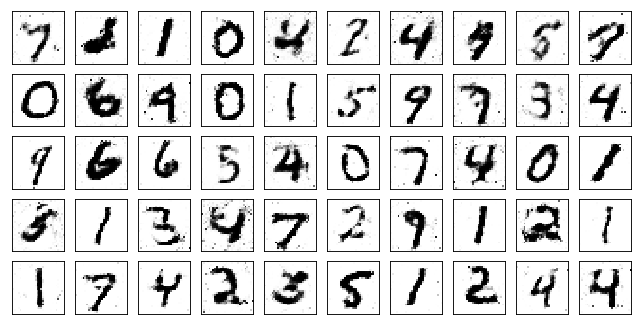

Test losses. G: 1.0709, D: 0.5812
Train Epoch: 44 [0/50000 (0%)]	Losses G: 1.0409, D: 0.6009
Train Epoch: 44 [5000/50000 (10%)]	Losses G: 1.0964, D: 0.5404
Train Epoch: 44 [10000/50000 (20%)]	Losses G: 1.3133, D: 0.6107
Train Epoch: 44 [15000/50000 (30%)]	Losses G: 1.2374, D: 0.5695
Train Epoch: 44 [20000/50000 (40%)]	Losses G: 1.3156, D: 0.5641
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 1.0686, D: 0.5869
Train Epoch: 44 [30000/50000 (60%)]	Losses G: 1.0254, D: 0.6240
Train Epoch: 44 [35000/50000 (70%)]	Losses G: 1.0651, D: 0.6010
Train Epoch: 44 [40000/50000 (80%)]	Losses G: 1.3533, D: 0.6398
Train Epoch: 44 [45000/50000 (90%)]	Losses G: 0.9453, D: 0.5670
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 1.1893, D: 0.5812


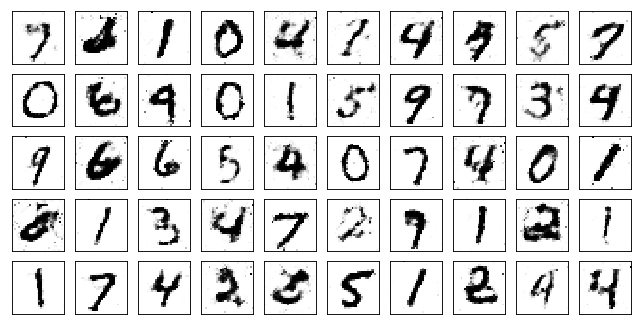

Test losses. G: 1.2005, D: 0.4880
Train Epoch: 45 [0/50000 (0%)]	Losses G: 1.1485, D: 0.4995
Train Epoch: 45 [5000/50000 (10%)]	Losses G: 0.8443, D: 0.6104
Train Epoch: 45 [10000/50000 (20%)]	Losses G: 0.9111, D: 0.6717
Train Epoch: 45 [15000/50000 (30%)]	Losses G: 0.9553, D: 0.5656
Train Epoch: 45 [20000/50000 (40%)]	Losses G: 1.1282, D: 0.5109
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 1.0031, D: 0.5836
Train Epoch: 45 [30000/50000 (60%)]	Losses G: 1.0175, D: 0.6489
Train Epoch: 45 [35000/50000 (70%)]	Losses G: 1.1171, D: 0.5574
Train Epoch: 45 [40000/50000 (80%)]	Losses G: 1.0129, D: 0.5585
Train Epoch: 45 [45000/50000 (90%)]	Losses G: 0.9385, D: 0.6508
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 1.3009, D: 0.6190


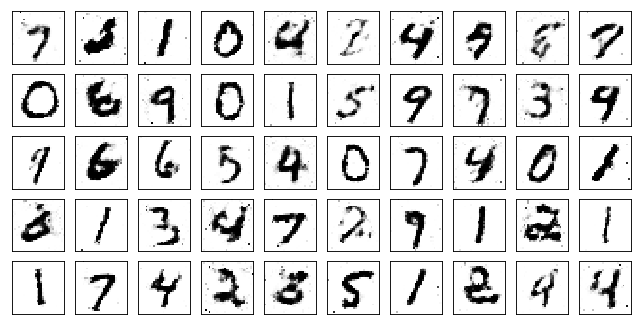

Test losses. G: 1.1398, D: 0.5930
Train Epoch: 46 [0/50000 (0%)]	Losses G: 1.2592, D: 0.6029
Train Epoch: 46 [5000/50000 (10%)]	Losses G: 0.9955, D: 0.5080
Train Epoch: 46 [10000/50000 (20%)]	Losses G: 1.0535, D: 0.6083
Train Epoch: 46 [15000/50000 (30%)]	Losses G: 1.1381, D: 0.5387
Train Epoch: 46 [20000/50000 (40%)]	Losses G: 1.0151, D: 0.5377
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 1.0411, D: 0.5813
Train Epoch: 46 [30000/50000 (60%)]	Losses G: 1.0200, D: 0.6787
Train Epoch: 46 [35000/50000 (70%)]	Losses G: 1.2339, D: 0.6065
Train Epoch: 46 [40000/50000 (80%)]	Losses G: 1.1951, D: 0.5395
Train Epoch: 46 [45000/50000 (90%)]	Losses G: 1.0092, D: 0.5640
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 1.0490, D: 0.5536


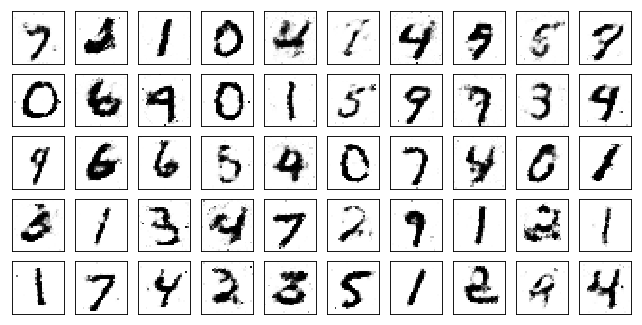

Test losses. G: 1.0346, D: 0.5433
Train Epoch: 47 [0/50000 (0%)]	Losses G: 0.9594, D: 0.6324
Train Epoch: 47 [5000/50000 (10%)]	Losses G: 1.0526, D: 0.5744
Train Epoch: 47 [10000/50000 (20%)]	Losses G: 1.0212, D: 0.6867
Train Epoch: 47 [15000/50000 (30%)]	Losses G: 1.1283, D: 0.5351
Train Epoch: 47 [20000/50000 (40%)]	Losses G: 1.2571, D: 0.5129
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 0.9230, D: 0.5785
Train Epoch: 47 [30000/50000 (60%)]	Losses G: 1.2683, D: 0.5459
Train Epoch: 47 [35000/50000 (70%)]	Losses G: 0.8806, D: 0.5719
Train Epoch: 47 [40000/50000 (80%)]	Losses G: 0.8023, D: 0.6186
Train Epoch: 47 [45000/50000 (90%)]	Losses G: 1.0705, D: 0.6157
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 1.1051, D: 0.5585


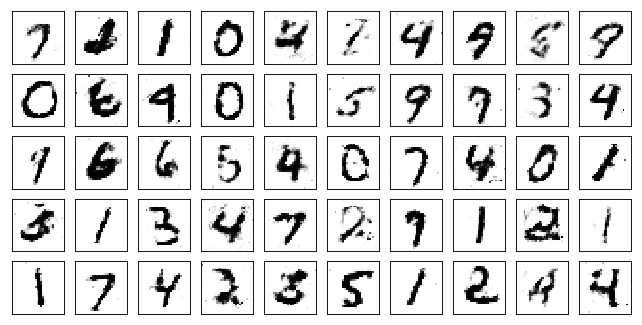

Test losses. G: 1.1167, D: 0.5083
Train Epoch: 48 [0/50000 (0%)]	Losses G: 1.0162, D: 0.5637
Train Epoch: 48 [5000/50000 (10%)]	Losses G: 1.2309, D: 0.6024
Train Epoch: 48 [10000/50000 (20%)]	Losses G: 1.0107, D: 0.6846
Train Epoch: 48 [15000/50000 (30%)]	Losses G: 1.1137, D: 0.5870
Train Epoch: 48 [20000/50000 (40%)]	Losses G: 1.0518, D: 0.6179
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 1.0567, D: 0.5308
Train Epoch: 48 [30000/50000 (60%)]	Losses G: 1.2141, D: 0.6642
Train Epoch: 48 [35000/50000 (70%)]	Losses G: 0.9758, D: 0.5501
Train Epoch: 48 [40000/50000 (80%)]	Losses G: 0.8256, D: 0.6511
Train Epoch: 48 [45000/50000 (90%)]	Losses G: 1.0508, D: 0.5780
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 0.8115, D: 0.6535


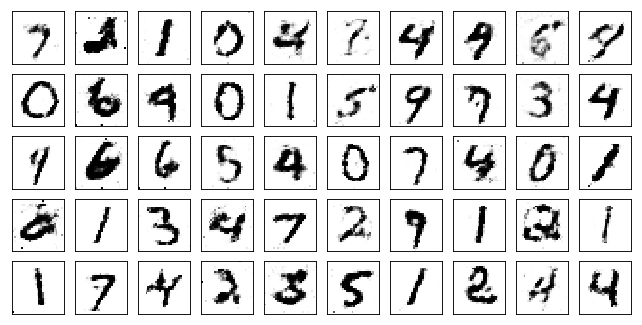

Test losses. G: 0.8286, D: 0.5857
Train Epoch: 49 [0/50000 (0%)]	Losses G: 0.9079, D: 0.5949
Train Epoch: 49 [5000/50000 (10%)]	Losses G: 1.0552, D: 0.5530
Train Epoch: 49 [10000/50000 (20%)]	Losses G: 0.9809, D: 0.6106
Train Epoch: 49 [15000/50000 (30%)]	Losses G: 1.1263, D: 0.6105
Train Epoch: 49 [20000/50000 (40%)]	Losses G: 1.0389, D: 0.6145
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 0.9874, D: 0.5913
Train Epoch: 49 [30000/50000 (60%)]	Losses G: 1.0779, D: 0.5485
Train Epoch: 49 [35000/50000 (70%)]	Losses G: 0.9104, D: 0.7157
Train Epoch: 49 [40000/50000 (80%)]	Losses G: 1.0828, D: 0.6950
Train Epoch: 49 [45000/50000 (90%)]	Losses G: 0.8378, D: 0.5785
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 0.8201, D: 0.6451


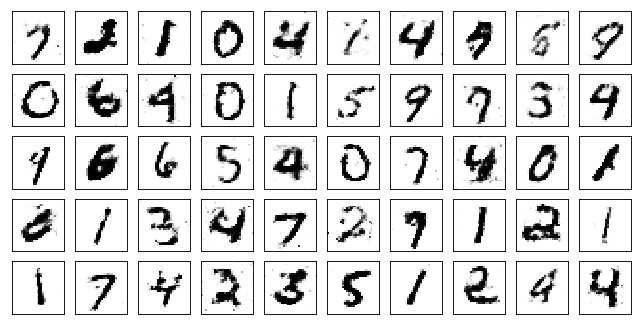

Test losses. G: 0.8493, D: 0.6126
Train Epoch: 50 [0/50000 (0%)]	Losses G: 0.8570, D: 0.7092
Train Epoch: 50 [5000/50000 (10%)]	Losses G: 0.9889, D: 0.5919
Train Epoch: 50 [10000/50000 (20%)]	Losses G: 1.2354, D: 0.5004
Train Epoch: 50 [15000/50000 (30%)]	Losses G: 0.9513, D: 0.6035
Train Epoch: 50 [20000/50000 (40%)]	Losses G: 1.0370, D: 0.5428
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 1.0272, D: 0.5395
Train Epoch: 50 [30000/50000 (60%)]	Losses G: 1.1919, D: 0.6038
Train Epoch: 50 [35000/50000 (70%)]	Losses G: 0.9057, D: 0.5942
Train Epoch: 50 [40000/50000 (80%)]	Losses G: 0.9163, D: 0.6096
Train Epoch: 50 [45000/50000 (90%)]	Losses G: 1.1215, D: 0.6216
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 1.1773, D: 0.5588


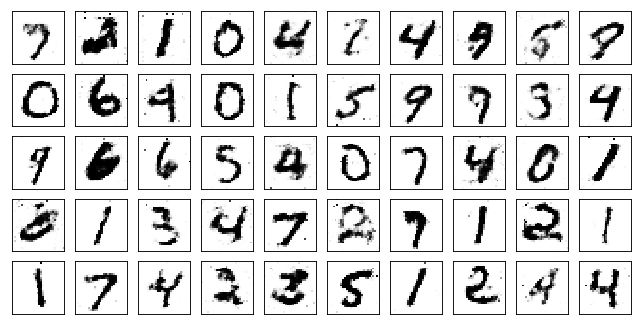

Test losses. G: 1.2268, D: 0.5113


In [13]:
for epoch in range(1, 51):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

In [14]:
torch.save(G, './generator')
torch.save(D, './discriminator')

/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
G = torch.load('./generator')

In [16]:
def show_generated_samples(cl):
    pred_z = torch.randn((50, 100))
    pred_cl = torch.ones(50, dtype=torch.long) * cl
    pred_oh = one_hot(y=pred_cl, batch_size=50)
    pred_h = torch.cat((pred_z, pred_oh), 1) 
       
    pred_gen = G(pred_h)
    generated = pred_gen.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()    
    plot_mnist(generated, (5, 10))

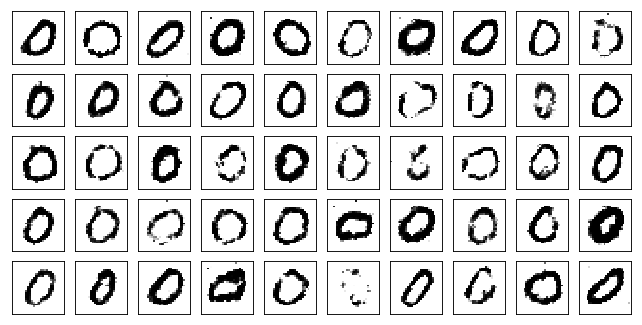

In [26]:
show_generated_samples(0)

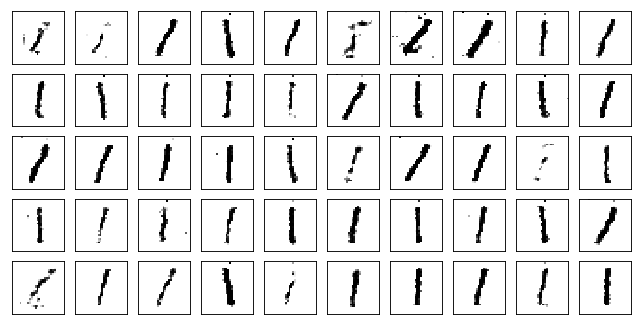

In [27]:
show_generated_samples(1)

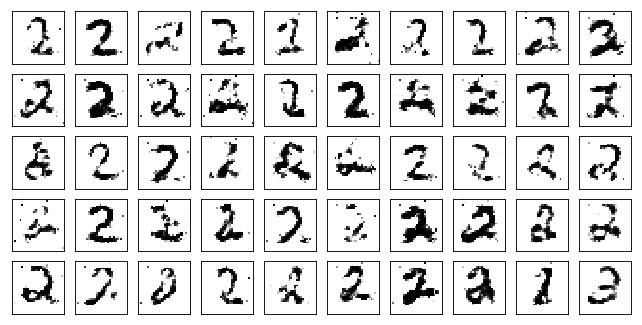

In [28]:
show_generated_samples(2)

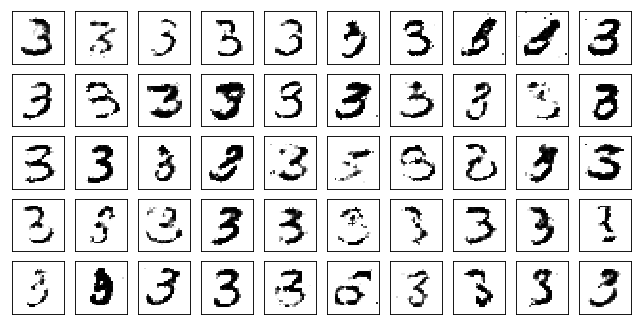

In [29]:
show_generated_samples(3)

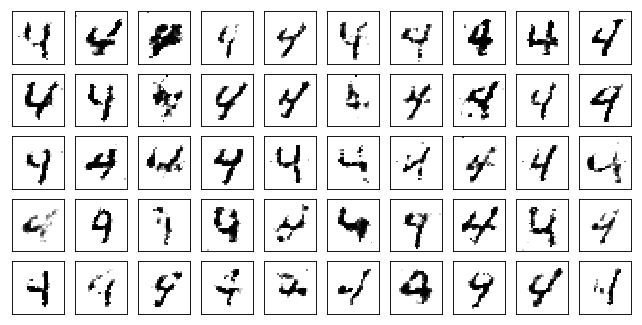

In [30]:
show_generated_samples(4)

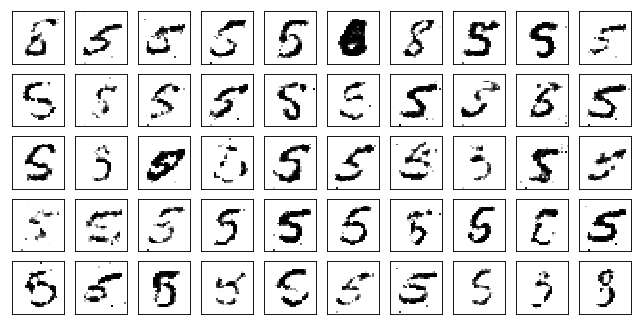

In [31]:
show_generated_samples(5)

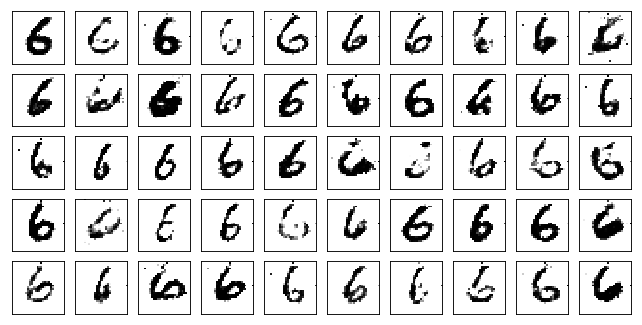

In [32]:
show_generated_samples(6)

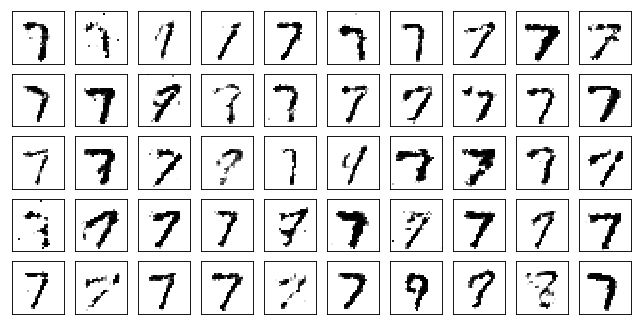

In [33]:
show_generated_samples(7)

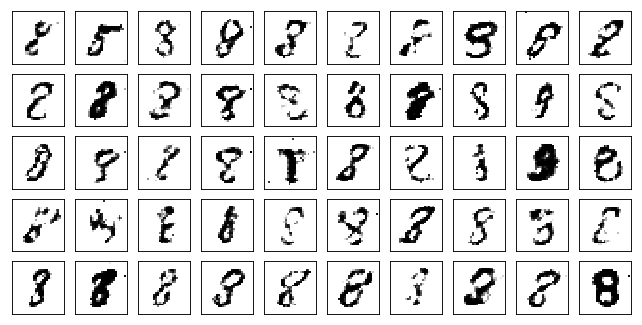

In [34]:
show_generated_samples(8)

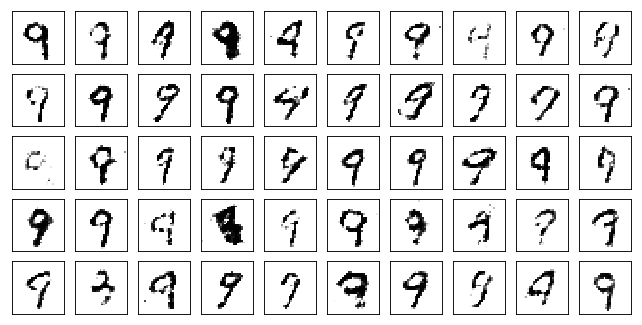

In [35]:
show_generated_samples(9)